In [1]:
from quaternions import *
from networks import *
from sim_helpers import *
from liegroups.numpy import SO3
import torch
from convex_layers import *

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 150

In [2]:
path = 'saved_data/synthetic/synthetic_wahba_experiment_12-11-2019-00-34-22.pt'
checkpoint = torch.load(path)
args = checkpoint['args']
A_net = ANet(num_pts=args.matches_per_sample, bidirectional=args.bidirectional_loss).double()
model = QuatNet(A_net=A_net)
print('Loading data...')
model.load_state_dict(checkpoint['model_rep'], strict=False)
print('Done')

Loading data...
Done


In [3]:
train_data, test_data = create_experimental_data(100, 1000, args.matches_per_sample, sigma=args.sim_sigma)

In [4]:
def l2_diff(a, b):
    return (a - b).norm(dim=1)
def acos_diff(a, b):
    return (180./3.1415)*torch.acos((a*b).sum(dim=1, keepdim=True)).squeeze()

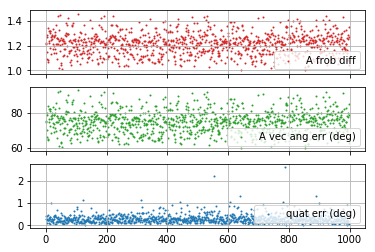

In [5]:
def _scatter(ax, x, y, title, color='tab:red'):
    ax.scatter(x, y, color=color, s=1, label=title)
    ax.grid()
    ax.legend(loc='lower right')
    return

model.eval()
i = torch.arange(0,test_data.x.shape[0])
with torch.no_grad():
    A_pred = model.A_net.forward(test_data.x[i])
    q_est = model.forward(test_data.x[i]).squeeze()
    
fig, ax = plt.subplots(3, 1, sharex='col', sharey='row')
_scatter(ax[0], i, l2_diff(A_pred, convert_A_to_Avec(test_data.A_prior[i])).numpy(), 'A frob diff', color='tab:red')
_scatter(ax[1], i, acos_diff(A_pred, convert_A_to_Avec(test_data.A_prior[i])).numpy(), 'A vec ang err (deg)',color='tab:green')
_scatter(ax[2], i, quat_angle_diff(q_est, test_data.q[i], reduce=False).numpy(), 'quat err (deg)', color='tab:blue')
plt.show()

In [13]:
el, ev = np.linalg.eig(convert_Avec_to_A(A_pred[0]).numpy())
print(el)
#print(ev)
#print(q_est[0])


[ 0.90680153 -1.01348636  0.05240327 -0.29313483]


In [14]:
A = test_data.A_prior[0].clone()
A = A/A.norm()
el, ev = np.linalg.eig(A.numpy())
print(el)
#print(ev)

[5.33073585e-13 8.11711407e-01 3.61023551e-01 4.59115004e-01]


In [15]:
matches = 36
sigma = 1e-10
#sigma_vec = sigma*np.random.randn(matches)
sigma_vec = sigma*np.ones(matches)

#sigma_vec[:int(matches/2)] *= np.random.randn(int(matches/2)) #Artificially scale half the noise

C, x_1, x_2 = gen_sim_data_grid(matches, sigma_vec, torch_vars=False, shuffle_points=False)
print(x_1)
A = build_A(x_1, x_2, sigma_2=sigma_vec**2)
A = A/np.linalg.norm(A)
el, ev = np.linalg.eig(A)
print(el)
print(ev)
print(np.linalg.matrix_rank(A))

[[-0.67317475 -0.67317475 -0.30605803]
 [-0.49774583 -0.82957638 -0.2530852 ]
 [-0.19503869 -0.97519345 -0.10467873]
 [ 0.19503869 -0.97519345  0.10467873]
 [ 0.49774583 -0.82957638  0.2530852 ]
 [ 0.67317475 -0.67317475  0.30605803]
 [-0.73674453 -0.44204672 -0.51166611]
 [-0.61978503 -0.61978503 -0.48138656]
 [-0.30610762 -0.91832287 -0.25096061]
 [ 0.30610762 -0.91832287  0.25096061]
 [ 0.61978503 -0.61978503  0.48138656]
 [ 0.73674453 -0.44204672  0.51166611]
 [-0.7624649  -0.15249298 -0.62880296]
 [-0.7139633  -0.23798777 -0.65849694]
 [-0.58244057 -0.58244057 -0.5670326 ]
 [ 0.58244057 -0.58244057  0.5670326 ]
 [ 0.7139633  -0.23798777  0.65849694]
 [ 0.7624649  -0.15249298  0.62880296]
 [-0.7624649   0.15249298 -0.62880296]
 [-0.7139633   0.23798777 -0.65849694]
 [-0.58244057  0.58244057 -0.5670326 ]
 [ 0.58244057  0.58244057  0.5670326 ]
 [ 0.7139633   0.23798777  0.65849694]
 [ 0.7624649   0.15249298  0.62880296]
 [-0.73674453  0.44204672 -0.51166611]
 [-0.61978503  0.61978503

In [9]:
matches = 16
C = SO3.exp(np.random.randn(3)).as_matrix()
#v = normalized(np.random.randn(1, 3))
#x_1 = np.concatenate((v, v))
x_1 = normalized(np.random.randn(matches, 3))
x_2 = C.dot(x_1.T).T 
A = build_A(x_1, x_2, sigma_2=np.ones(matches))
A = A / np.linalg.norm(A)

print(A)
el, ev = np.linalg.eig(A)
print(el)
#print(ev)
print(np.linalg.det(A))
print(np.linalg.matrix_rank(A))

# B = 4*np.eye(4) + 2*Omega_l(pure_quat(x_2[0])).dot(
#             Omega_r(pure_quat(x_1[0]))) + 2*Omega_l(pure_quat(x_2[1])).dot(
#             Omega_r(pure_quat(x_1[1])))
# B = B / np.linalg.norm(B)
# print(B)
# print(np.linalg.eig(B))


[[ 0.3892776  -0.25622368 -0.00555849  0.19676847]
 [-0.25622368  0.35298648  0.05587282  0.12844546]
 [-0.00555849  0.05587282  0.50717551  0.05564206]
 [ 0.19676847  0.12844546  0.05564206  0.46087502]]
[0.         0.44478784 0.65907645 0.60645034]
1.3803775106769947e-18
3


In [10]:
convert_Avec_to_A(torch.arange(10))

tensor([[0, 1, 2, 3],
        [1, 4, 5, 6],
        [2, 5, 7, 8],
        [3, 6, 8, 9]])

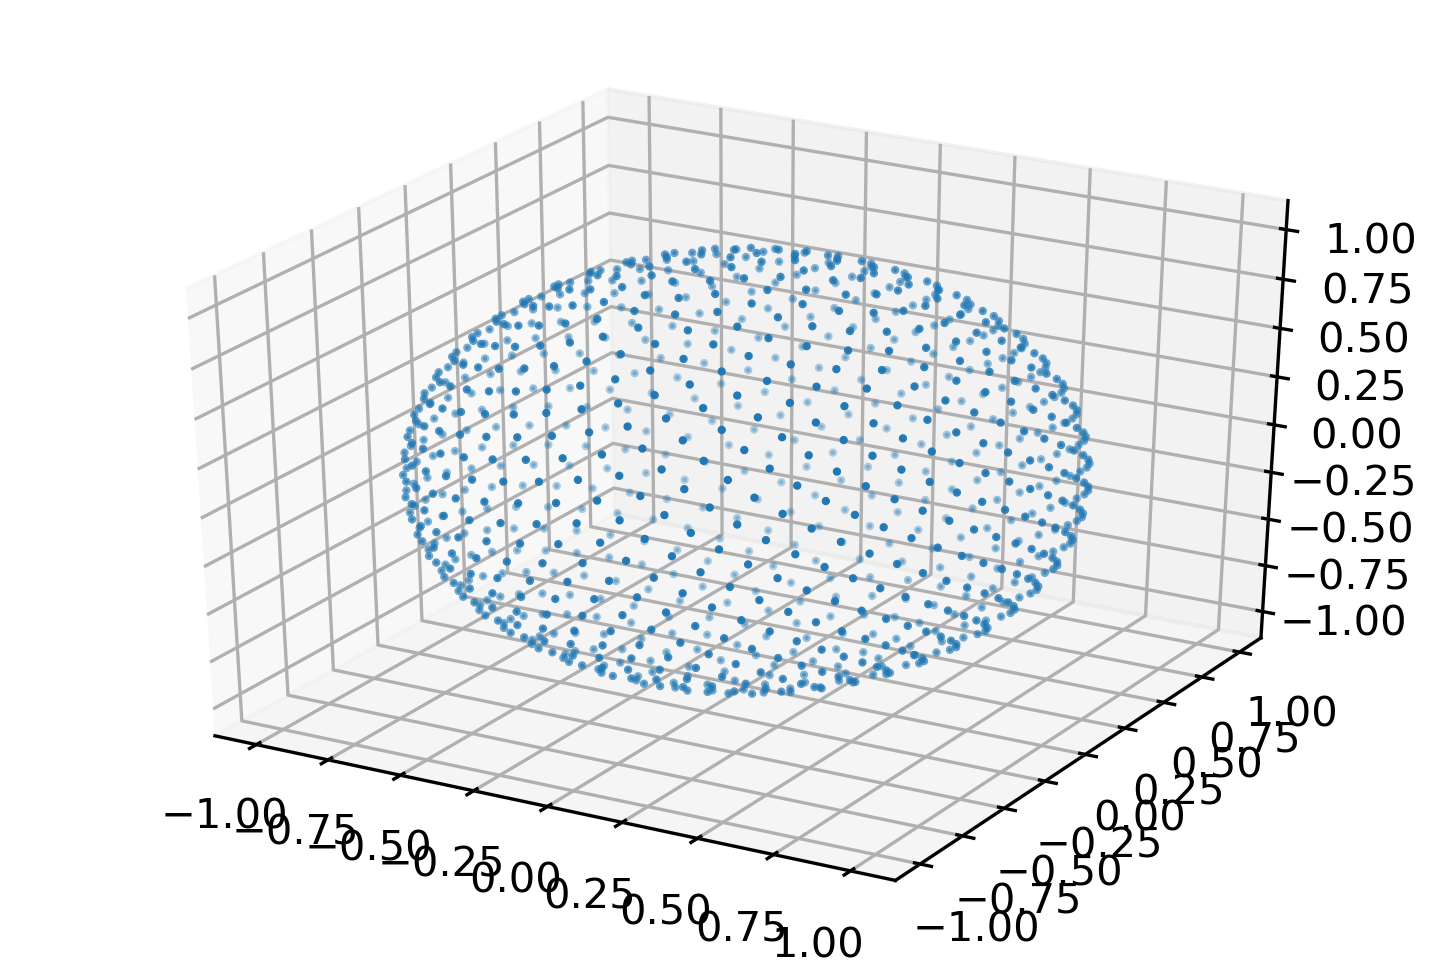

In [9]:
from numpy import pi, cos, sin, arccos, arange
import mpl_toolkits.mplot3d
import matplotlib.pyplot as pp
%matplotlib inline
pp.rcParams['figure.dpi'] = 300

num_pts = 1000
indices = arange(0, num_pts, dtype=float) + 0.5

phi = arccos(1 - 2*indices/num_pts)
theta = pi * (1 + 5**0.5) * indices

x, y, z = cos(theta) * sin(phi), sin(theta) * sin(phi), cos(phi);

pp.figure().add_subplot(111, projection='3d').scatter(x, y, z, s=1.);
pp.show()

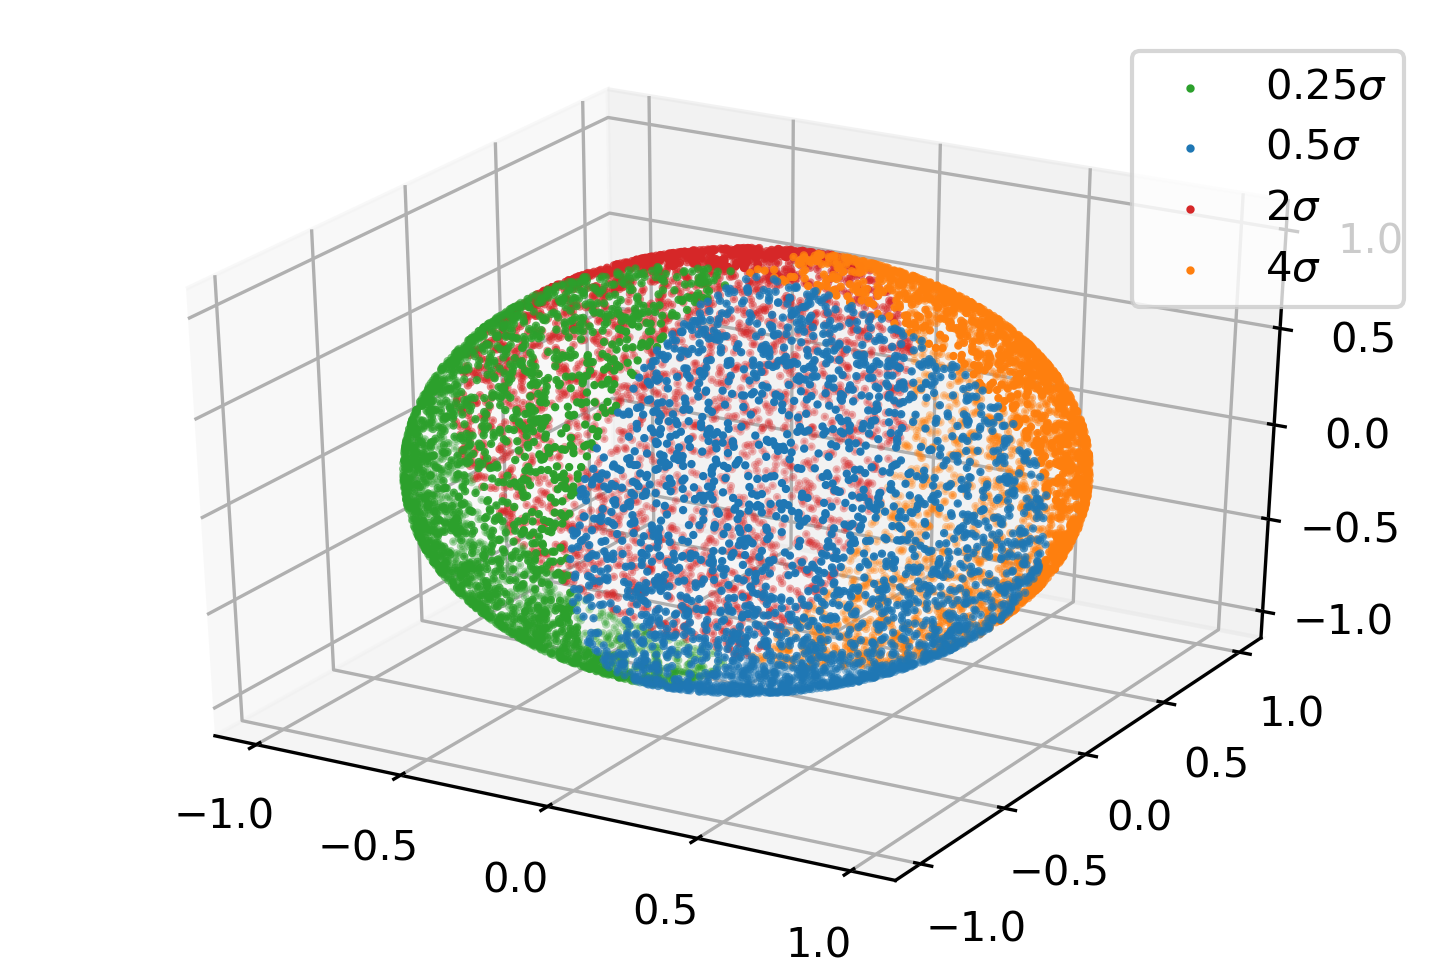

In [38]:
import torch
num_pts = 10000
pts = torch.randn(3, num_pts)
pts = pts / pts.norm(dim=0, keepdim=True)
region_masks = [(pts[0] < 0.) & (pts[1] < 0.), 
                (pts[0] >= 0.) & (pts[1] < 0.), 
                (pts[0] < 0.) & (pts[1] >= 0.), 
                (pts[0] >= 0.) & (pts[1] >= 0.)]
ax = pp.figure().add_subplot(111, projection='3d')

colours = ['tab:green', 'tab:blue', 'tab:red', 'tab:orange']
labels = ['$0.25 \sigma$','$0.5 \sigma$','$2 \sigma$','$4 \sigma$']
for m_i, mask in enumerate(region_masks):
    ax.scatter(pts[0, mask].numpy(), pts[1, mask].numpy(), pts[2, mask].numpy(), s=1., c=colours[m_i], label=labels[m_i])
ax.legend()
ax.grid(which='both')
ax.set_yticks(torch.arange(-1, 1.1, step=0.5))
ax.set_xticks(torch.arange(-1, 1.1, step=0.5))
ax.set_zticks(torch.arange(-1, 1.1, step=0.5))

pp.show()